- Grupo

-- Henrico Nardelli Bela - RM95985

-- Felype Nunes - RM96232

-- Daniel Faria - RM94026

-- Emilly Gabriely - RM94437

-- Sara Leal - RM96302


# Clusterizacao - Case ImdbMovies

# IMDb TOP 250 Movies
![An image](https://static.amazon.jobs/teams/53/images/IMDb_Header_Page.jpg?1501027252)

**Este projeto consiste em treinar um sistema de recomendação de filmes utilizando as informações referentes aos top 250 filmes melhor avaliados pelo público na plataforma IMDb.**
*   A extração dos dados será feita por técnicas de web scraping (crawler).
*   O objetivo principal será agrupar os 250 filmes em "n" clusters classificados a partir das suas sinopses, aplicando técnicas de processamento de texto e algoritmos de clusterização.
*   Ao final, teremos um sistemas de recomendação baseado na similaridade das sinopses, e não apenas dos generos.

**Exemplo de aplicação prática: usuários receberão recomendações de filmes que estejam no mesmo cluster de sinopses de outros filmes que ele já tenha curtido.**

# Import das bibliotecas

In [1]:
# !pip install pycaret==3.0.2

In [2]:
import pandas as pd
import numpy as np
import requests
#from pprint import pprint
#from bs4 import BeautifulSoup
#import re
#import json
#from urllib.request import Request, urlopen
#from lxml import html
import time
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from pycaret.clustering import *

## DataFrame

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

#EDA - Exploratory Data Analysis

In [4]:
# path_to_export = '/Users/henricobela/Desktop/Estudos/Github/Python/Faculdade/FIAP/Segundo_ano/2o_semestre/AUTOML/Clustering/atividade_clustering/raw_data' #mac
path_to_export = '/home/henrico/Github/Faculdade/FIAP/Segundo_ano/2o_semestre/AUTOML/Clustering/atividade_clustering/raw_data' #linux
df = pd.read_csv(f'{path_to_export}/all_movies.csv', sep = ';')

df = df[["title_pt", "title_en", "year", "rating", "genre", "sinopse"]]

print(df.shape)
df.head()

(357, 6)


title_pt                              title_en  \
0                       Besouro Azul                       1. Besouro Azul   
1                             Barbie                             2. Barbie   
2                        Oppenheimer                        3. Oppenheimer   
3  As Tartarugas Ninja: Caos Mutante  4. As Tartarugas Ninja: Caos Mutante   
4                  Ruim Pra Cachorro                  5. Ruim Pra Cachorro   

   year      rating      genre  \
0  2023   6.8 (17K)       Ação   
1  2023  7.4 (255K)   Aventura   
2  2023  8.6 (381K)  Biografia   
3  2023   7.5 (19K)   Animação   
4  2023  6.4 (3.2K)   Animação   

                                             sinopse  
0  Jaime Reyes, um adolescente de origem mexicana...  
1  Viver na Terra da Barbie é ser um ser perfeito...  
2  A história do cientista americano J. Robert Op...  
3  Os irmãos Tartaruga trabalham para conquistar ...  
4  Um cachorro abandonado se une a outros vira-la...

In [5]:
# Adjusting variable types
df['year'] = df['year'].astype('int64')
df["rating"] = df["rating"].apply(lambda x: x.split("\xa0")[0] if not isinstance(x, float) else x)
idx = df[df.rating.isin(["Rate"])].index.tolist()
df.loc[idx, "rating"] = 6.0
df['rating'] = df['rating'].astype('float64')
df.rating.fillna(6.0, inplace = True)
df.dropna(inplace = True)
df

title_pt  \
0                                 Besouro Azul   
1                                       Barbie   
2                                  Oppenheimer   
3            As Tartarugas Ninja: Caos Mutante   
4                            Ruim Pra Cachorro   
..                                         ...   
352                  Meus Sogros Tão pro Crime   
353                                    Dunkirk   
354                       Guardiões da Galáxia   
355                                    Titanic   
356  Você Não Tá Convidada pro Meu Bat Mitzvá!   

                                      title_en  year  rating      genre  \
0                              1. Besouro Azul  2023     6.8       Ação   
1                                    2. Barbie  2023     7.4   Aventura   
2                               3. Oppenheimer  2023     8.6  Biografia   
3         4. As Tartarugas Ninja: Caos Mutante  2023     7.5   Animação   
4                         5. Ruim Pra Cachorro  2023     6.4   Animação   
..                                         ...   ...     ...        ...   
352                  Meus Sogros Tão pro Crime  2023     5.4       Ação   
353                                    Dunkirk  2017     7.8       Ação   
354                       Guardiões da Galáxia  2014     8.0       Ação   
355                                    Titanic  1997     7.9      Drama   
356  Você Não Tá Convidada pro Meu Bat Mitzvá!  2023     6.0    Comédia   

                                               sinopse  
0    Jaime Reyes, um adolescente de origem mexicana...  
1    Viver na Terra da Barbie é ser um ser perfeito...  
2    A história do cientista americano J. Robert Op...  
3    Os irmãos Tartaruga trabalham para conquistar ...  
4    Um cachorro abandonado se une a outros vira-la...  
..                                                 ...  
352  Um conservador gerente de banco prestes a se c...  
353  Soldados aliados da Bélgica, do Império Britân...  
354  Um grupo de criminosos intergalácticos deve se...  
355  Uma aristocrata de dezessete anos se apaixona ...  
356  Stacey Friedman se prepara para seu bat mitzva...  

[355 rows x 6 columns]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 355 entries, 0 to 356
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   title_pt  355 non-null    object 
 1   title_en  355 non-null    object 
 2   year      355 non-null    int64  
 3   rating    355 non-null    float64
 4   genre     355 non-null    object 
 5   sinopse   355 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 19.4+ KB


In [7]:
df.describe()

year      rating
count   355.000000  355.000000
mean   1996.819718    7.800845
std      26.757251    0.966661
min    1921.000000    3.200000
25%    1980.000000    7.600000
50%    2004.000000    8.100000
75%    2022.000000    8.300000
max    2024.000000    9.300000

## Plots

In [8]:
df.genre.value_counts('d')

Ação                 0.245070
Drama                0.225352
Comédia              0.121127
Policial             0.109859
Animação             0.081690
Biografia            0.078873
Aventura             0.070423
Terror               0.042254
Mistério             0.011268
Faroeste             0.002817
Filme noir           0.002817
Fantasia             0.002817
Suspense             0.002817
Ficção científica    0.002817
Name: genre, dtype: float64

In [9]:
fig = px.bar(df.genre.value_counts('d')*100,
             text_auto=True,
             title = '% de Filmes por Gênero',
             labels={'index':'Gênero',
                     'value':'% de Filmes'})
fig.show()

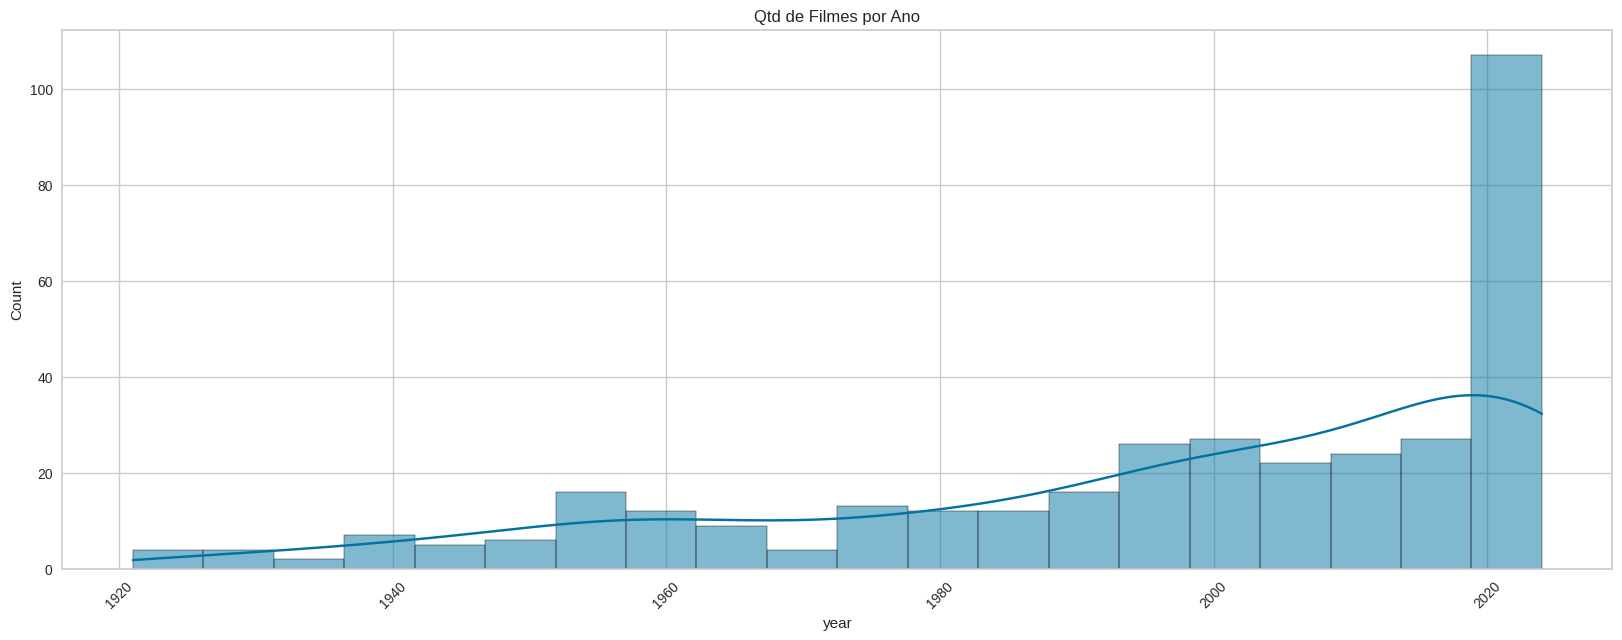

In [10]:
plt.figure(figsize = (20,7))
sns.histplot( df,
              x = 'year',
              kde = True, bins = 20).set_title('Qtd de Filmes por Ano')
plt.xticks(rotation=45)
plt.show()

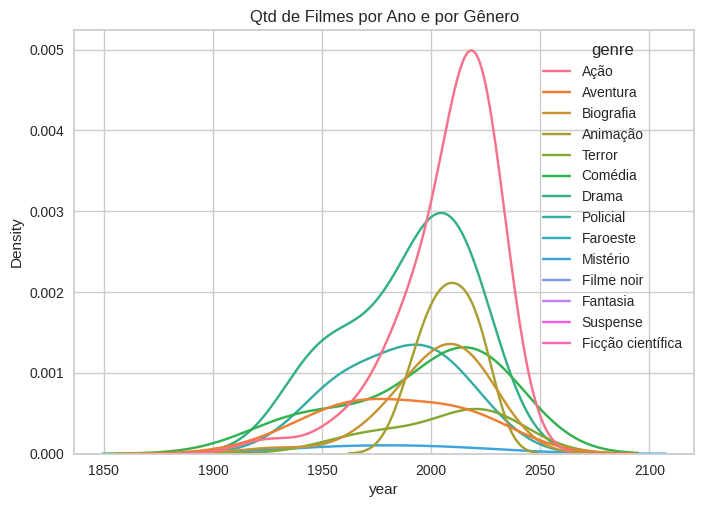

In [11]:
sns.kdeplot( df, x = 'year', hue = 'genre', bw_adjust = 1.5, warn_singular = False).set_title('Qtd de Filmes por Ano e por Gênero')
plt.show()

# Pré-processamento de texto

In [12]:
#convert sinopses to lowercase
df_processed = df.copy()
df_processed['sinopse'] = df_processed['sinopse'].str.lower()
df_processed['sinopse'].head()

0    jaime reyes, um adolescente de origem mexicana...
1    viver na terra da barbie é ser um ser perfeito...
2    a história do cientista americano j. robert op...
3    os irmãos tartaruga trabalham para conquistar ...
4    um cachorro abandonado se une a outros vira-la...
Name: sinopse, dtype: object

In [13]:
def qty_words(text):
    words= text.split()
    word_count = len(words)
    return word_count

In [14]:
### Feature Engineering
df_processed['word_count'] = df_processed['sinopse'].apply(qty_words).astype('int64')
df_processed.head()

title_pt                              title_en  \
0                       Besouro Azul                       1. Besouro Azul   
1                             Barbie                             2. Barbie   
2                        Oppenheimer                        3. Oppenheimer   
3  As Tartarugas Ninja: Caos Mutante  4. As Tartarugas Ninja: Caos Mutante   
4                  Ruim Pra Cachorro                  5. Ruim Pra Cachorro   

   year  rating      genre                                            sinopse  \
0  2023     6.8       Ação  jaime reyes, um adolescente de origem mexicana...   
1  2023     7.4   Aventura  viver na terra da barbie é ser um ser perfeito...   
2  2023     8.6  Biografia  a história do cientista americano j. robert op...   
3  2023     7.5   Animação  os irmãos tartaruga trabalham para conquistar ...   
4  2023     6.4   Animação  um cachorro abandonado se une a outros vira-la...   

   word_count  
0          24  
1          29  
2          17  
3          19  
4          15

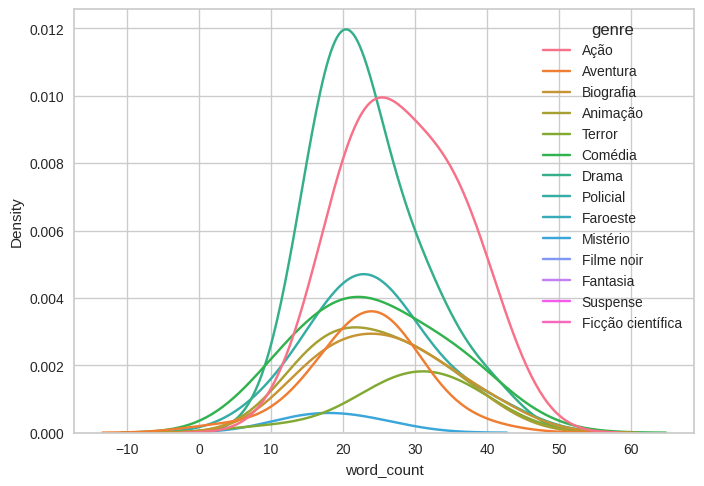

In [15]:
sns.kdeplot( df_processed, x = 'word_count', hue = 'genre', bw_adjust = 1.5, warn_singular = False)
plt.show()

## Nuvem de palavras

### Antes de remover as stopwords

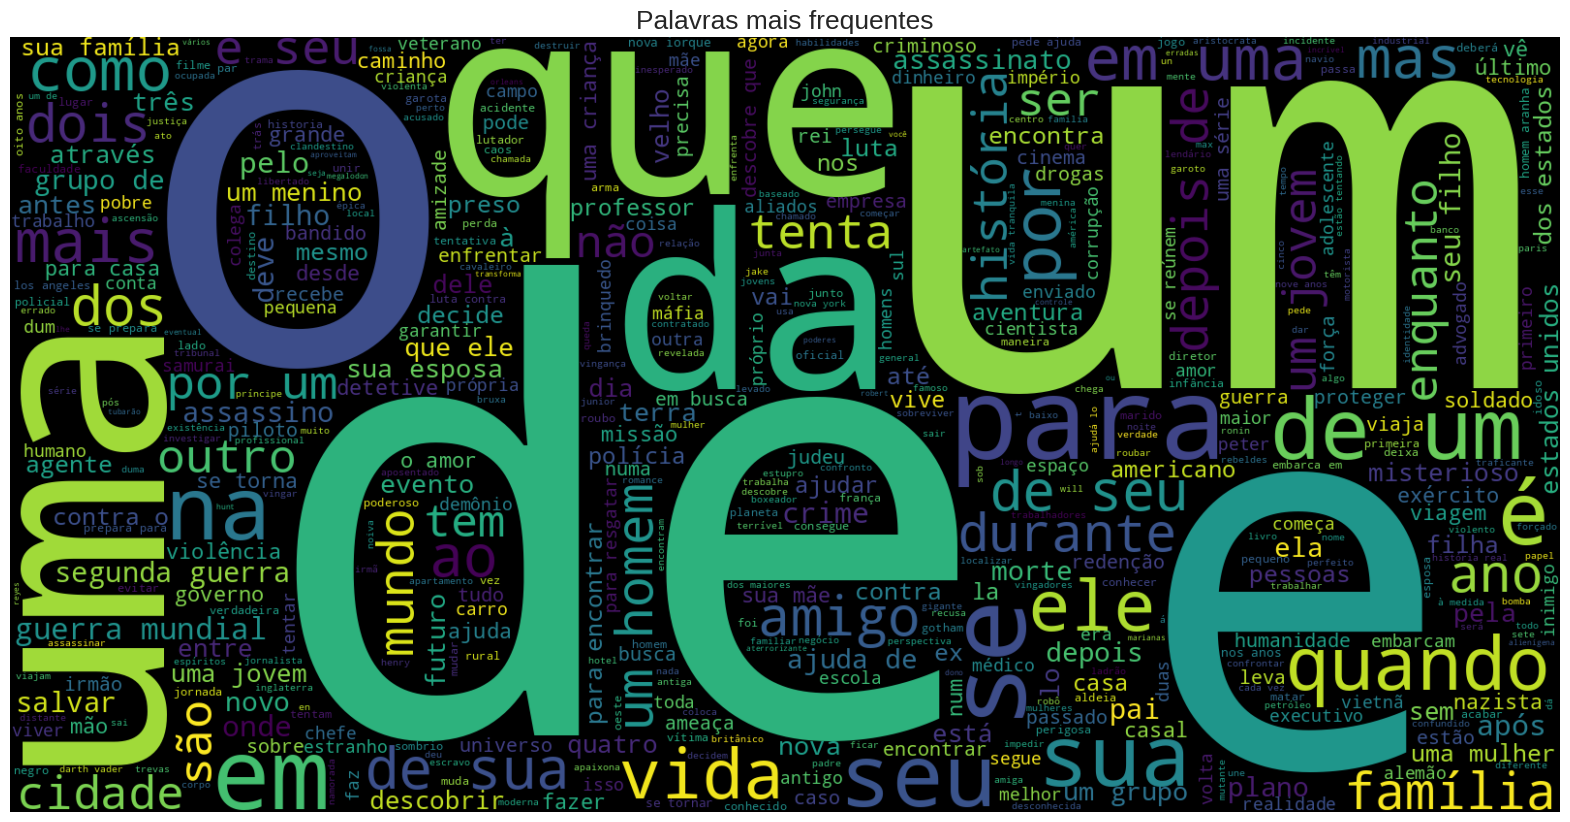

In [16]:
text = ' '.join([phrase for phrase in df_processed['sinopse']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palavras mais frequentes', fontsize = 19)
plt.show()

### Após remoção das stopwords

In [17]:
import nltk
nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('portuguese')
print(stopwords)

['a', 'à', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'às', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele', 'deles', 'depois', 'do', 'dos', 'e', 'é', 'ela', 'elas', 'ele', 'eles', 'em', 'entre', 'era', 'eram', 'éramos', 'essa', 'essas', 'esse', 'esses', 'esta', 'está', 'estamos', 'estão', 'estar', 'estas', 'estava', 'estavam', 'estávamos', 'este', 'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estivéramos', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivéssemos', 'estou', 'eu', 'foi', 'fomos', 'for', 'fora', 'foram', 'fôramos', 'forem', 'formos', 'fosse', 'fossem', 'fôssemos', 'fui', 'há', 'haja', 'hajam', 'hajamos', 'hão', 'havemos', 'haver', 'hei', 'houve', 'houvemos', 'houver', 'houvera', 'houverá', 'houveram', 'houvéramos', 'houverão', 'houverei', 'houverem', 'houveremos', 'houveria', 'houveriam', 'houveríamos', 'houvermos', 'houvesse', 'houvessem', 'houvésse

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/henrico/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


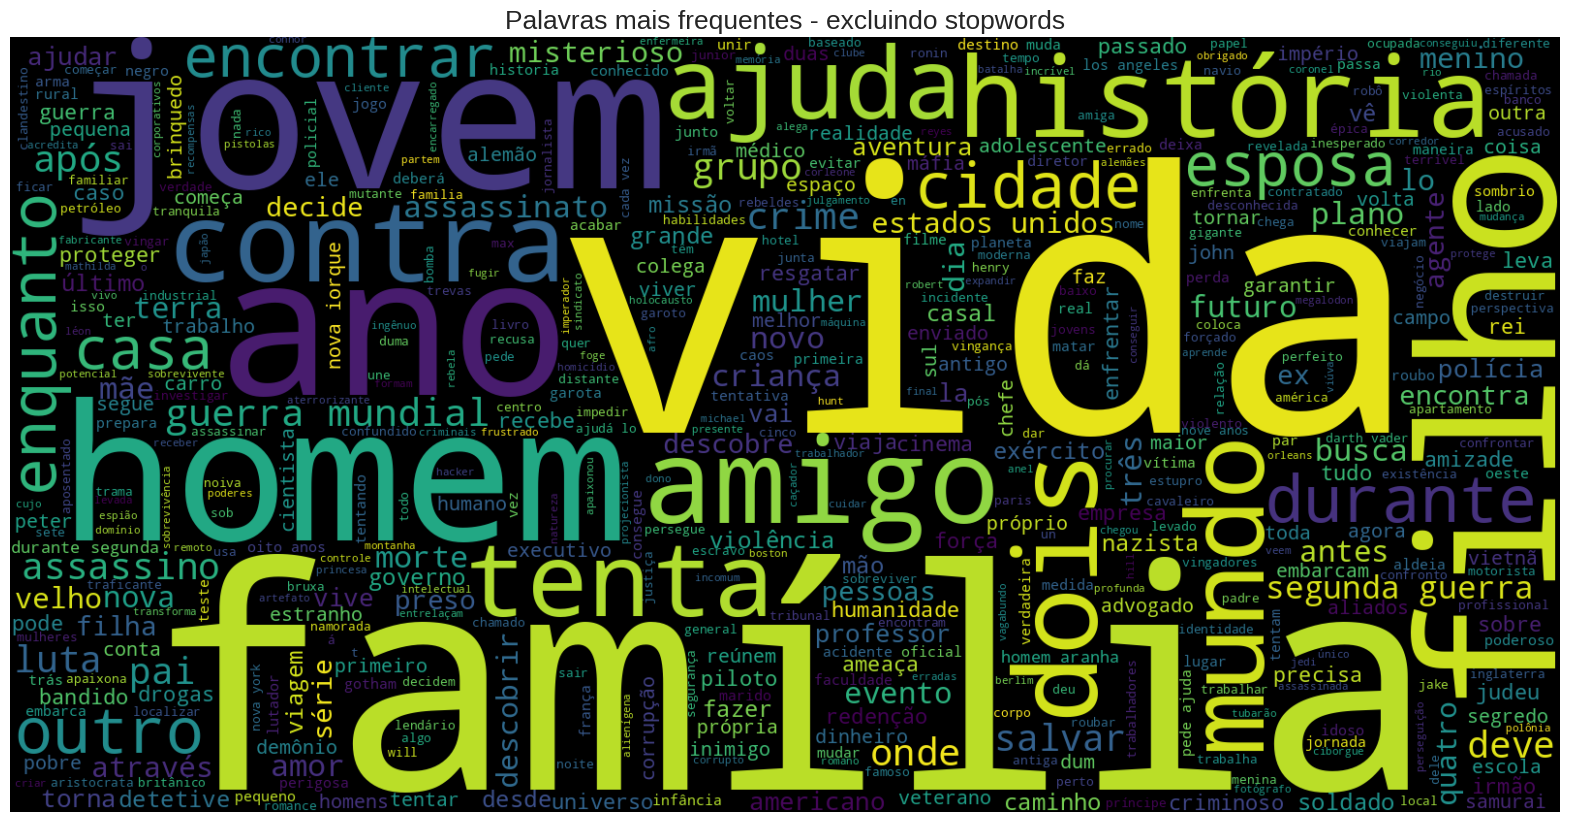

In [18]:
df_processed['sinopse_no_stopwords'] = df_processed['sinopse'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
text = ' '.join([phrase for phrase in df_processed['sinopse_no_stopwords']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palavras mais frequentes - excluindo stopwords', fontsize = 19)
plt.show()

## Aplicando TF-IDF
Term Frequency-Inverse Document Frequency

O TF-IDF define a importância de um termo levando em consideração a importância desse termo em um único documento e dimensionando-o por sua importância em todos os documentos.

In [19]:
# initialize the vectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
# fit_transform applies TF-IDF to clean texts - we save the array of vectors in X
X = vectorizer.fit_transform(df_processed['sinopse_no_stopwords'])

In [20]:
print(X.shape)
X.toarray()

(355, 154)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.75043195, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

# AutoML | PyCaret - Clustering

## Setup

In [21]:
s = setup(data = X.toarray(),
          session_id = 123)

# Create Model

In [22]:
mdl_kmeans = create_model('kmeans')

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [23]:
mdl_dbscan = create_model('dbscan')

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [24]:
mdl_meanshift = create_model('meanshift')

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

# Assign Model

In [25]:
df_kmeans = assign_model(mdl_kmeans)
display(df_kmeans.Cluster.value_counts())
df_kmeans

Cluster 0    170
Cluster 2     89
Cluster 3     64
Cluster 1     32
Name: Cluster, dtype: int64

feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0          0.0        0.0        0.0        0.0   0.000000   0.000000   
1          0.0        0.0        0.0        0.0   0.000000   0.000000   
2          0.0        0.0        0.0        0.0   0.000000   0.000000   
3          0.0        0.0        0.0        0.0   0.000000   0.000000   
4          0.0        0.0        0.0        0.0   0.000000   0.000000   
..         ...        ...        ...        ...        ...        ...   
350        0.0        0.0        0.0        0.0   0.000000   0.000000   
351        0.0        0.0        0.0        0.0   0.401654   0.401654   
352        0.0        0.0        0.0        0.0   0.000000   0.000000   
353        0.0        0.0        0.0        0.0   0.000000   0.000000   
354        0.0        0.0        0.0        0.0   0.000000   0.000000   

     feature_7  feature_8  feature_9  feature_10  ...  feature_146  \
0          0.0   0.000000        0.0         0.0  ...          0.0   
1          0.0   0.000000        0.0         0.0  ...          0.0   
2          0.0   0.777677        0.0         0.0  ...          0.0   
3          0.0   0.000000        0.0         0.0  ...          0.0   
4          0.0   0.000000        0.0         0.0  ...          0.0   
..         ...        ...        ...         ...  ...          ...   
350        0.0   0.000000        0.0         0.0  ...          0.0   
351        0.0   0.000000        0.0         0.0  ...          0.0   
352        0.0   0.000000        0.0         0.0  ...          0.0   
353        0.0   0.000000        0.0         0.0  ...          0.0   
354        0.0   0.000000        0.0         0.0  ...          0.0   

     feature_147  feature_148  feature_149  feature_150  feature_151  \
0       0.000000          0.0          0.0          0.0          0.0   
1       0.000000          0.0          0.0          0.0          0.0   
2       0.000000          0.0          0.0          0.0          0.0   
3       0.000000          0.0          0.0          0.0          0.0   
4       0.000000          0.0          0.0          0.0          0.0   
..           ...          ...          ...          ...          ...   
350     0.507967          0.0          0.0          0.0          0.0   
351     0.000000          0.0          0.0          0.0          0.0   
352     0.000000          0.0          0.0          0.0          0.0   
353     0.000000          0.0          0.0          0.0          0.0   
354     0.000000          0.0          0.0          0.0          0.0   

     feature_152  feature_153  feature_154    Cluster  
0       0.000000          0.0          0.0  Cluster 2  
1       0.750432          0.0          0.0  Cluster 0  
2       0.000000          0.0          0.0  Cluster 0  
3       0.000000          0.0          0.0  Cluster 0  
4       0.000000          0.0          0.0  Cluster 0  
..           ...          ...          ...        ...  
350     0.000000          0.0          0.0  Cluster 1  
351     0.000000          0.0          0.0  Cluster 2  
352     0.000000          0.0          0.0  Cluster 0  
353     0.000000          0.0          0.0  Cluster 3  
354     0.000000          0.0          0.0  Cluster 0  

[355 rows x 155 columns]

In [26]:
df_db = assign_model(mdl_dbscan)
df_db.Cluster.value_counts()

Cluster -1    346
Cluster 0       9
Name: Cluster, dtype: int64

In [27]:
df_meanshift = assign_model(mdl_meanshift)
df_meanshift.Cluster.value_counts()

Cluster 0    355
Name: Cluster, dtype: int64

# Analyze Models

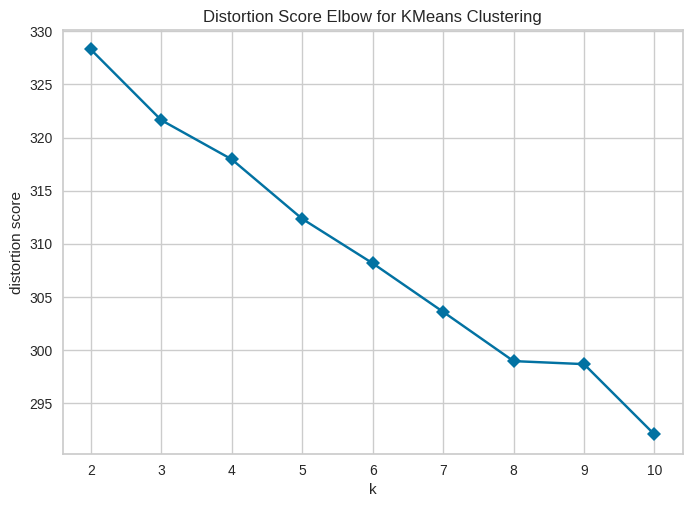

In [28]:
plot_model(mdl_kmeans, plot = 'elbow')

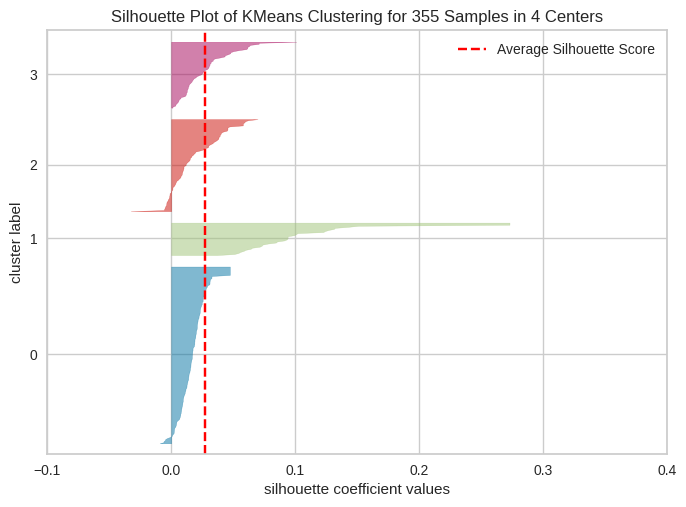

In [29]:
plot_model(mdl_kmeans, plot = 'silhouette')

In [30]:
plot_model(mdl_kmeans, plot = 'distribution')

In [31]:
plot_model(mdl_kmeans, plot = 'cluster')

In [32]:
plot_model(mdl_kmeans, plot = 'tsne')

In [33]:
evaluate_model(mdl_kmeans)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

# Filmes por cluster

In [34]:
df_processed['cluster'] = df_kmeans['Cluster']
df_processed

title_pt  \
0                                 Besouro Azul   
1                                       Barbie   
2                                  Oppenheimer   
3            As Tartarugas Ninja: Caos Mutante   
4                            Ruim Pra Cachorro   
..                                         ...   
352                  Meus Sogros Tão pro Crime   
353                                    Dunkirk   
354                       Guardiões da Galáxia   
355                                    Titanic   
356  Você Não Tá Convidada pro Meu Bat Mitzvá!   

                                      title_en  year  rating      genre  \
0                              1. Besouro Azul  2023     6.8       Ação   
1                                    2. Barbie  2023     7.4   Aventura   
2                               3. Oppenheimer  2023     8.6  Biografia   
3         4. As Tartarugas Ninja: Caos Mutante  2023     7.5   Animação   
4                         5. Ruim Pra Cachorro  2023     6.4   Animação   
..                                         ...   ...     ...        ...   
352                  Meus Sogros Tão pro Crime  2023     5.4       Ação   
353                                    Dunkirk  2017     7.8       Ação   
354                       Guardiões da Galáxia  2014     8.0       Ação   
355                                    Titanic  1997     7.9      Drama   
356  Você Não Tá Convidada pro Meu Bat Mitzvá!  2023     6.0    Comédia   

                                               sinopse  word_count  \
0    jaime reyes, um adolescente de origem mexicana...          24   
1    viver na terra da barbie é ser um ser perfeito...          29   
2    a história do cientista americano j. robert op...          17   
3    os irmãos tartaruga trabalham para conquistar ...          19   
4    um cachorro abandonado se une a outros vira-la...          15   
..                                                 ...         ...   
352  um conservador gerente de banco prestes a se c...          33   
353  soldados aliados da bélgica, do império britân...          25   
354  um grupo de criminosos intergalácticos deve se...          20   
355  uma aristocrata de dezessete anos se apaixona ...          20   
356  stacey friedman se prepara para seu bat mitzva...          19   

                                  sinopse_no_stopwords    cluster  
0    jaime reyes, adolescente origem mexicana encon...  Cluster 2  
1    viver terra barbie perfeito lugar perfeito. me...  Cluster 0  
2    história cientista americano j. robert oppenhe...  Cluster 0  
3    irmãos tartaruga trabalham conquistar amor cid...  Cluster 0  
4    cachorro abandonado une outros vira-latas ving...  Cluster 0  
..                                                 ...        ...  
352  conservador gerente banco prestes casar amor v...  Cluster 0  
353  soldados aliados bélgica, império britânico fr...  Cluster 3  
354  grupo criminosos intergalácticos deve unir imp...  Cluster 0  
355  aristocrata dezessete anos apaixona artista ge...        NaN  
356  stacey friedman prepara bat mitzvah, planos de...        NaN  

[355 rows x 9 columns]

## % de Gêneros por Cluster

In [35]:
fig = px.bar(df_processed.cluster.value_counts(),
             text_auto = True,
             title = 'Qtd de Filmes por Cluster',
             labels = {'index': 'Cluster #',
                       'value':'Qtd. de Filmes'})
fig.show()

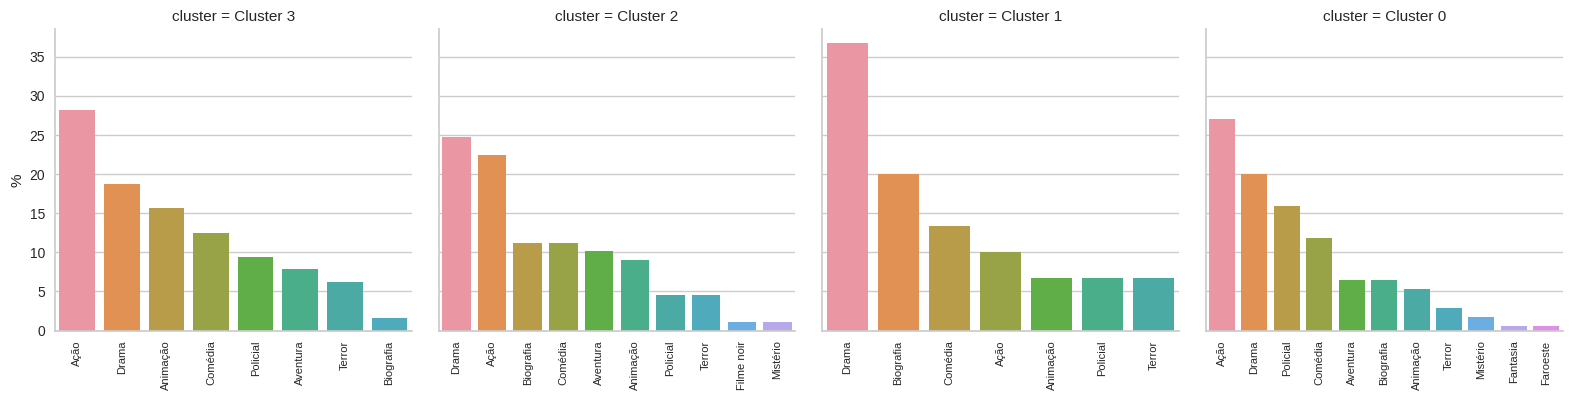

In [36]:
df_plot = df_processed.groupby(['cluster', 'genre'])['title_pt'].count()
df_plot = df_plot.reset_index()
df_plot.rename(columns = {'title_pt':'count'}, inplace = True)
df_plot['%'] = 100 * df_plot['count'] / df_plot.groupby('cluster')['count'].transform('sum')
df_plot = df_plot.sort_values(['cluster', '%'], ascending = False).groupby('cluster').head(11)

fig = sns.catplot(
    data=df_plot, x="genre", y = "%", col="cluster",
    kind="bar", height=4, aspect=1, sharex = False);
fig.set_xlabels('');
fig.set_xticklabels(rotation=90, size = 8);

## Ano de Lançamento por Cluster

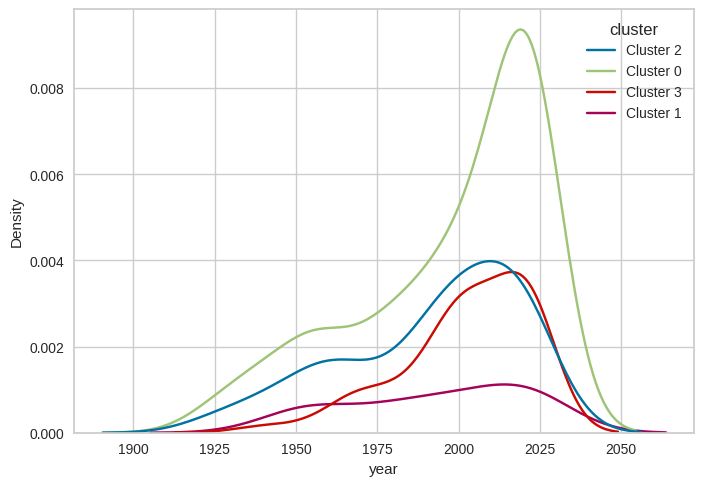

In [37]:
sns.kdeplot(df_processed, x = 'year', hue = 'cluster');

## Radar | Gêneros por Cluster

In [38]:
df_pivot = df_plot.copy()
df_pivot = df_pivot.pivot(index = 'cluster', columns = 'genre', values = '%')
df_pivot.fillna(0, inplace = True)
df_pivot = df_pivot.T.reset_index()
df_pivot.index.name = None
df_pivot

cluster       genre  Cluster 0  Cluster 1  Cluster 2  Cluster 3
0          Animação   5.294118   6.666667   8.988764    15.6250
1          Aventura   6.470588   0.000000  10.112360     7.8125
2              Ação  27.058824  10.000000  22.471910    28.1250
3         Biografia   6.470588  20.000000  11.235955     1.5625
4           Comédia  11.764706  13.333333  11.235955    12.5000
5             Drama  20.000000  36.666667  24.719101    18.7500
6          Fantasia   0.588235   0.000000   0.000000     0.0000
7          Faroeste   0.588235   0.000000   0.000000     0.0000
8        Filme noir   0.000000   0.000000   1.123596     0.0000
9          Mistério   1.764706   0.000000   1.123596     0.0000
10         Policial  15.882353   6.666667   4.494382     9.3750
11           Terror   2.941176   6.666667   4.494382     6.2500

In [39]:
df_polar = df_pivot.melt(id_vars=['genre'])
df_polar.head()

genre    cluster      value
0   Animação  Cluster 0   5.294118
1   Aventura  Cluster 0   6.470588
2       Ação  Cluster 0  27.058824
3  Biografia  Cluster 0   6.470588
4    Comédia  Cluster 0  11.764706

In [40]:
fig = px.line_polar(df_polar, r='value', theta='genre', color = 'cluster', line_close=True)
fig.show();

# Nuvem de Palavras por Cluster

# Considerações Finais
* **Exercício: Reescrever as análises / conclusões devido a atualização da base**

Cluster 2


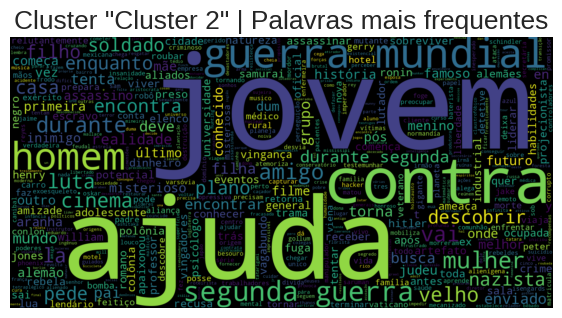

Cluster 0


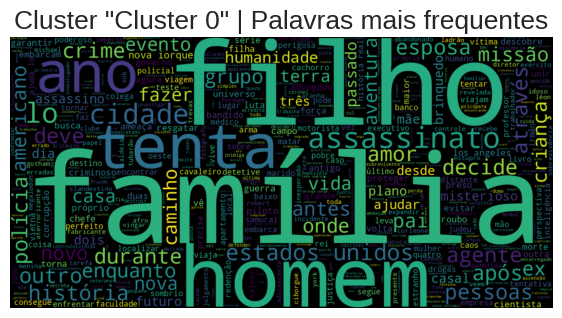

Cluster 3


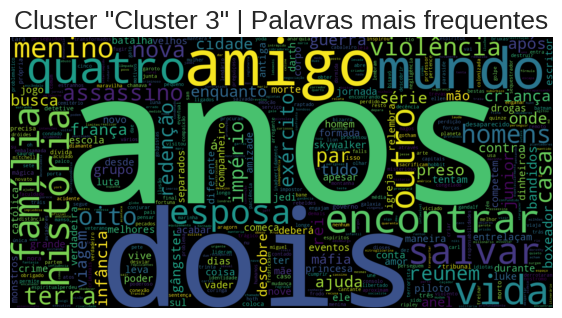

Cluster 1


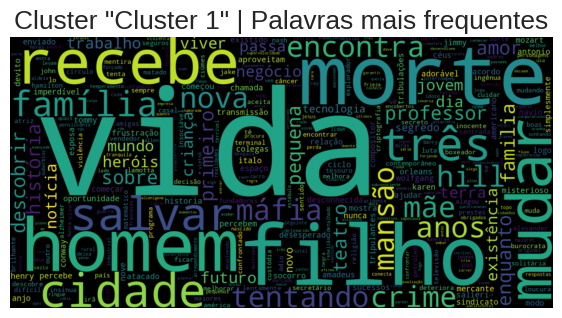

nan


In [41]:
def word_cloud_cluster(cluster:int):
  text = ' '.join([phrase for phrase in df_processed.loc[df_processed.cluster == cluster]['sinopse_no_stopwords']])
  plt.figure(figsize=(7,5), facecolor='None')
  wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'Cluster "{cluster}" | Palavras mais frequentes', fontsize = 19)
  plt.show()
  return

list_clusters = df_processed.cluster.unique().tolist()
for c in list_clusters:
  print(c)
  if str(c) != "nan":
    word_cloud_cluster(c)

## Analises antes da insercao de mais features para o modelo

** Diferentemente do notebook que foi utilizado anteriormente, usando kmeans, e metodos como Davies Boundin Score e Calisnki, neste notebook, podemos obter uma analise diferenciada, ao utilizar apenas uma feature, e posteriormente, o uso de mais features do nosso dataset de filmes, (que foi retroalimentado durante alguns dias, atravez de um crawler do site imdb movies. 

Ao todo foram extraidas 357 amostras), entretanto, devida ao baixo numero de amostras, nao foi possivel atender exatamente aos clusters necessarios, vale salientar, que, no notebook que foi utilizado os metodos de Davies e Calinski, foram obtidos resultados mais satisfatorios. Vale a pena o teste para ver qual o melhor modelo para o nosso app de recomendacao.**

1. Na secao de Create Model (usando apenas uma feature), foram apresentados 3 tipos de abordagens, kmeans, dbscan, e meanshift. A priore, Kmeans apresentou melhores metricas.



2. Depois, foi analisados os plots dos modelos, que nos metodos de 'elbow', 'silhouette', 'distribution', 'cluster' e 'tsne'.
  
  2.1 Metodo elbow: A curva de distircao nao foi tao expressiva, aparentemente por conta das poucas amostras.
  
  2.2 Metodo Silhouette: Ja as sihlouetas para cada cluster detectado pelo modelo tambem nao apresentaram bons valores de coeficiente.
  
  2.3 Metodo de Distribution: Apesar de poucas amostras no dataset, o modelo conseguiu separar em 4 clusters quase que igualmente todas as amostras.
  
  2.4 Metodo de Cluster: Em uma visao 2D da reducao de dimensionalidade (PCA), e possivel identificar que os clusters 0, 2 e 3 estao bem proximos.
  
  2.5 Metodo TSNE: Com esta visualizacao, nao foi possivel ter uma boa identificacao da separacao exata dos clusters, possivelmente por conta da baixa quantidade de amostras.



3. Depois foi analisado o % de cada gênero por cluster, sendo os dois gêneros mais representativos do:
  
  2.1 Cluster 0: Acao, Drama, Animacao, Comedia, Policial, Aventura, Terror e Biografia.
  
  2.2 Cluster 1: Drama, Acao, Biografia, Comedia, Aventura, Animacao, Policial, Terror, Filme Noir, Misterio 
  
  2.3 Cluster 2: Drama, Biografia, Comedia, Acao, Animacao, Policial, Terror.
  
  2.4 Cluster 3: Acao, Drama, Policial, Comedia, Aventura, Biografia, Animacao, Terror, Misterio, Fantasia, Faroeste

  - Vale salientar que com o pycaret, os generos de Fantasia, e Faroeste, que na analise do notebook anterior, nao apareceram. 
  - Entretanto, no notebook anterior, sem o uso do Pycaret, os clusters nao tiveram uma diferenciacao significativa (10 clusters anteriormente).



4. Na sequência foi avaliado a distribuição dos anos de lançamento dos filmes por cluster, agora com menos clusters podemos ver com exatidao qual cluster e em qual ano ele esta com a maior densidade. Novamente, cluster 0 com a maior densidade.


5. O grafico de radar apresentado, pode ser analisado com os seguintes pontos:
  
  5.1 Todos os cluster com melhor visibilidade, porem os generos: Filme Noir, Faroeste, Fantasia e Misterio, ainda continuam nao recebendo a devida atencao do modelo. Muito provavelmente por conta das poucas amostras.



6. E finalmente, foram apresentadas as nuvens de palavras por cluster, onde em linhas gerais destacam-se:
  
  6.1 Diferentemente do notebook anterior, os clusters nao apresentaram uma exatidao tao alta para com o filme Senhor dos aneis, porem um maior agrupamento por genero, que no caso, e o objetivo da atividade!
  
  6.2 Cluster 2: Guerra Mundial, Jovem, Homem, Segunda Guerra, Nazista, General. (Genero Acao, Acertou!!!)
  
  6.3 Cluster 0: Filho, Familia, Homem, Estados unidos, Politica, Cidade, Humanidade. (Genero Drama, Acertou!!!)
  
  6.4 Cluster 3: Esposa, Familia, Historia, Terra, Encontrar, Salvar, Violencia. (Generos identificados: Drama, Policial, Aventura, Acredito que tenha acertado!)
  
  6.5 Cluster 1: Salvar, Vida, Familia, Recebe, Morte, Filho, Mae, Mafia. (Generos: Acao, Drama, Polial)



** Em resumo neste projeto foram aplicados conceitos de:


1. Webscraping / Crawler para coleta de dados do site IMDb



2. Pré-processamento de texto com utilização de técnicas de NLP, limpeza do texto, lemmatização, remoção de stopwords, remoção de pontuação, remoção de acentuação.



3. Tecnicas e abordagens diferentes para definir o numero adequado de clusters, que, a partir desses resultados, foi denifido que o numero de clusters mais adequado é o de 10 clusters, e conforme acima, foi possivel obter bons resultados, metodos:
 
  3.1 Metodo Elbow
  
  3.2 Metodo Silhouette
  
  3.3 Metodo Davies Bouldin Score
  
  3.4 Metodo Calinski Harabasz Score



4. Clusterização



5. Pycaret
  
  5.1 Utilizando tanto 1 quanto varias features para os clusters. 



Desta forma consideramos que o objetivo inicial foi atingido sendo possível a clusterização dos filmes baseado na sinopse / descrição de cada um, gerando desta forma a possibilidade de recomendar filmes aos usuários não apenas pela classificação tradicional por gêneros, mas também pelos clusters identificados neste projeto.

Os posters dos filmes foram extraidos do site tambem, para que assim, futuramente possamos realizar uma melhor analise com base nas imagens, e tambem, dar um melhor retorno ao solicitante, ao recomendar um filme!
A extraçao dessas imagens de posters foi feita atravez de webscrapping e arrays numpy, onde baixamos a imagem em ioBytes e a convertemos em escala de cinza, posteriormente em array numpy.

**Em termos práticos, se um usuário avalia positivamente um filme, os filmes pertecentes ao mesmo cluster podem ser recomendados a ele.**


# Adicionando demais features do df all_movies ao X

In [42]:
pd.DataFrame(X.toarray()).shape

(355, 154)

In [43]:
df_processed.shape

(355, 9)

In [44]:
df_all = pd.concat([
                    df_processed.drop('cluster', axis = 1),
                    pd.DataFrame(X.toarray())
                   ]
                   , axis = 1
                   )
df_all

title_pt  \
0                                 Besouro Azul   
1                                       Barbie   
2                                  Oppenheimer   
3            As Tartarugas Ninja: Caos Mutante   
4                            Ruim Pra Cachorro   
..                                         ...   
354                       Guardiões da Galáxia   
355                                    Titanic   
356  Você Não Tá Convidada pro Meu Bat Mitzvá!   
275                                        NaN   
290                                        NaN   

                                      title_en    year  rating      genre  \
0                              1. Besouro Azul  2023.0     6.8       Ação   
1                                    2. Barbie  2023.0     7.4   Aventura   
2                               3. Oppenheimer  2023.0     8.6  Biografia   
3         4. As Tartarugas Ninja: Caos Mutante  2023.0     7.5   Animação   
4                         5. Ruim Pra Cachorro  2023.0     6.4   Animação   
..                                         ...     ...     ...        ...   
354                       Guardiões da Galáxia  2014.0     8.0       Ação   
355                                    Titanic  1997.0     7.9      Drama   
356  Você Não Tá Convidada pro Meu Bat Mitzvá!  2023.0     6.0    Comédia   
275                                        NaN     NaN     NaN        NaN   
290                                        NaN     NaN     NaN        NaN   

                                               sinopse  word_count  \
0    jaime reyes, um adolescente de origem mexicana...        24.0   
1    viver na terra da barbie é ser um ser perfeito...        29.0   
2    a história do cientista americano j. robert op...        17.0   
3    os irmãos tartaruga trabalham para conquistar ...        19.0   
4    um cachorro abandonado se une a outros vira-la...        15.0   
..                                                 ...         ...   
354  um grupo de criminosos intergalácticos deve se...        20.0   
355  uma aristocrata de dezessete anos se apaixona ...        20.0   
356  stacey friedman se prepara para seu bat mitzva...        19.0   
275                                                NaN         NaN   
290                                                NaN         NaN   

                                  sinopse_no_stopwords    0    1  ...  144  \
0    jaime reyes, adolescente origem mexicana encon...  0.0  0.0  ...  0.0   
1    viver terra barbie perfeito lugar perfeito. me...  0.0  0.0  ...  0.0   
2    história cientista americano j. robert oppenhe...  0.0  0.0  ...  0.0   
3    irmãos tartaruga trabalham conquistar amor cid...  0.0  0.0  ...  0.0   
4    cachorro abandonado une outros vira-latas ving...  0.0  0.0  ...  0.0   
..                                                 ...  ...  ...  ...  ...   
354  grupo criminosos intergalácticos deve unir imp...  0.0  0.0  ...  0.0   
355  aristocrata dezessete anos apaixona artista ge...  NaN  NaN  ...  NaN   
356  stacey friedman prepara bat mitzvah, planos de...  NaN  NaN  ...  NaN   
275                                                NaN  0.0  0.0  ...  0.0   
290                                                NaN  0.0  0.0  ...  0.0   

     145       146  147  148  149  150       151  152  153  
0    0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  
1    0.0  0.000000  0.0  0.0  0.0  0.0  0.750432  0.0  0.0  
2    0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  
3    0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  
4    0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  
..   ...       ...  ...  ...  ...  ...       ...  ...  ...  
354  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  
355  NaN       NaN  NaN  NaN  NaN  NaN       NaN  NaN  NaN  
356  NaN       NaN  NaN  NaN  NaN  NaN       NaN  NaN  NaN  
275  0.0  0.301708  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  
290  0.0  0.267499  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  

[

# Setup

In [45]:
s = setup(data = df_all,
          session_id = 123)

In [46]:
mdl_kmeans_all = create_model('kmeans')

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

# Evaluate Model

In [47]:
evaluate_model(mdl_kmeans_all)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [48]:
plot_model(mdl_kmeans_all, plot = "cluster")

In [49]:
plot_model(mdl_kmeans_all, plot = "tsne")

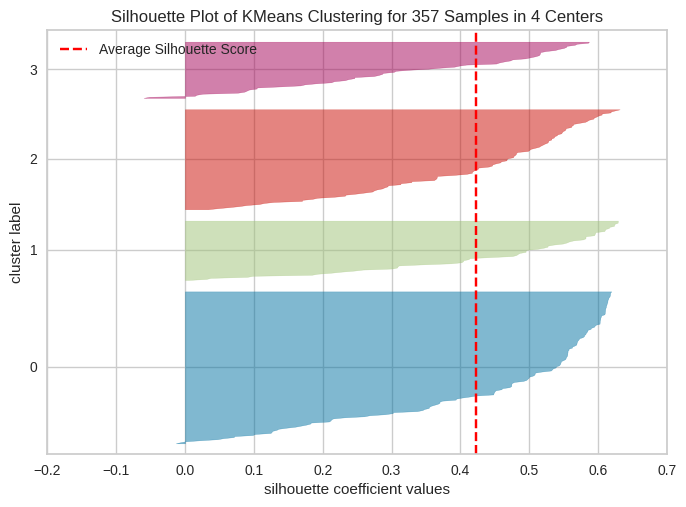

In [50]:
plot_model(mdl_kmeans_all, plot = 'silhouette')

In [51]:
plot_model(mdl_kmeans_all, plot = 'distribution')

In [52]:
df_kmeans_all = assign_model(mdl_kmeans_all)
df_kmeans_all

title_pt  \
0                                 Besouro Azul   
1                                       Barbie   
2                                  Oppenheimer   
3            As Tartarugas Ninja: Caos Mutante   
4                            Ruim Pra Cachorro   
..                                         ...   
354                       Guardiões da Galáxia   
355                                    Titanic   
356  Você Não Tá Convidada pro Meu Bat Mitzvá!   
275                                        NaN   
290                                        NaN   

                                      title_en    year  rating      genre  \
0                              1. Besouro Azul  2023.0     6.8       Ação   
1                                    2. Barbie  2023.0     7.4   Aventura   
2                               3. Oppenheimer  2023.0     8.6  Biografia   
3         4. As Tartarugas Ninja: Caos Mutante  2023.0     7.5   Animação   
4                         5. Ruim Pra Cachorro  2023.0     6.4   Animação   
..                                         ...     ...     ...        ...   
354                       Guardiões da Galáxia  2014.0     8.0       Ação   
355                                    Titanic  1997.0     7.9      Drama   
356  Você Não Tá Convidada pro Meu Bat Mitzvá!  2023.0     6.0    Comédia   
275                                        NaN     NaN     NaN        NaN   
290                                        NaN     NaN     NaN        NaN   

                                               sinopse  word_count  \
0    jaime reyes, um adolescente de origem mexicana...        24.0   
1    viver na terra da barbie é ser um ser perfeito...        29.0   
2    a história do cientista americano j. robert op...        17.0   
3    os irmãos tartaruga trabalham para conquistar ...        19.0   
4    um cachorro abandonado se une a outros vira-la...        15.0   
..                                                 ...         ...   
354  um grupo de criminosos intergalácticos deve se...        20.0   
355  uma aristocrata de dezessete anos se apaixona ...        20.0   
356  stacey friedman se prepara para seu bat mitzva...        19.0   
275                                                NaN         NaN   
290                                                NaN         NaN   

                                  sinopse_no_stopwords    0    1  ...  145  \
0    jaime reyes, adolescente origem mexicana encon...  0.0  0.0  ...  0.0   
1    viver terra barbie perfeito lugar perfeito. me...  0.0  0.0  ...  0.0   
2    história cientista americano j. robert oppenhe...  0.0  0.0  ...  0.0   
3    irmãos tartaruga trabalham conquistar amor cid...  0.0  0.0  ...  0.0   
4    cachorro abandonado une outros vira-latas ving...  0.0  0.0  ...  0.0   
..                                                 ...  ...  ...  ...  ...   
354  grupo criminosos intergalácticos deve unir imp...  0.0  0.0  ...  0.0   
355  aristocrata dezessete anos apaixona artista ge...  NaN  NaN  ...  NaN   
356  stacey friedman prepara bat mitzvah, planos de...  NaN  NaN  ...  NaN   
275                                                NaN  0.0  0.0  ...  0.0   
290                                                NaN  0.0  0.0  ...  0.0   

          146  147  148  149  150       151  152  153    Cluster  
0    0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  Cluster 0  
1    0.000000  0.0  0.0  0.0  0.0  0.750432  0.0  0.0  Cluster 0  
2    0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  Cluster 0  
3    0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  Cluster 0  
4    0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  Cluster 0  
..        ...  ...  ...  ...  ...       ...  ...  ...        ...  
354  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  Cluster 0  
355       NaN  NaN  NaN  NaN  NaN       NaN  NaN  NaN  Cluster 2  
356       NaN  NaN  NaN  NaN  NaN       NaN  NaN  NaN  Cluster 0  
275  0.301708  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  Cluster 2

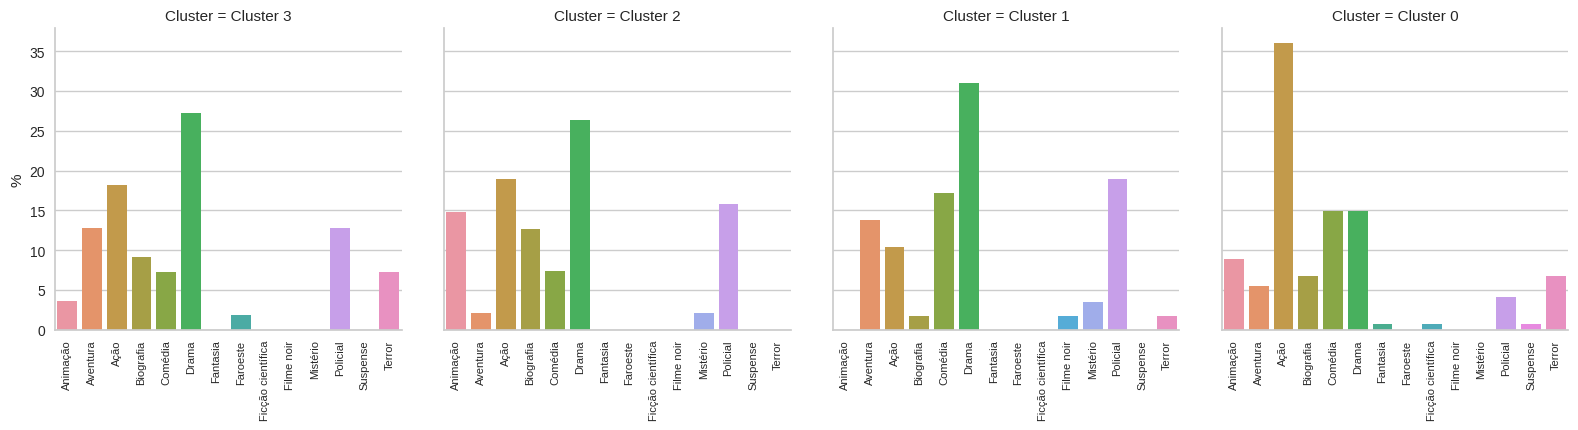

In [56]:
df_plot = df_kmeans_all.groupby(['Cluster', 'genre'])['title_pt'].count()
df_plot = df_plot.reset_index()
df_plot.rename(columns = {'title_pt':'count'}, inplace = True)
df_plot['%'] = 100 * df_plot['count'] / df_plot.groupby('Cluster')['count'].transform('sum')
df_plot = df_plot.sort_values(['Cluster', '%'], ascending = False).groupby('Cluster').head(11)

fig = sns.catplot(
    data=df_plot, x="genre", y = "%", col="Cluster",
    kind="bar", height=4, aspect=1, sharex = False);
fig.set_xlabels('');
fig.set_xticklabels(rotation=90, size = 8);

Cluster 0


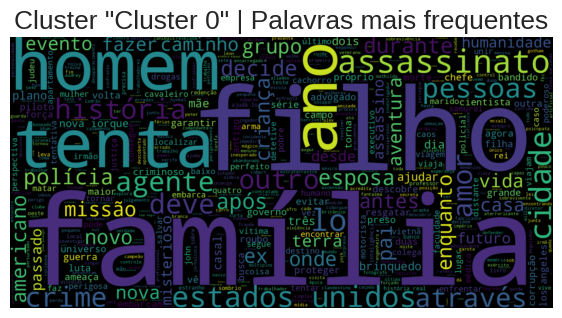

Cluster 2


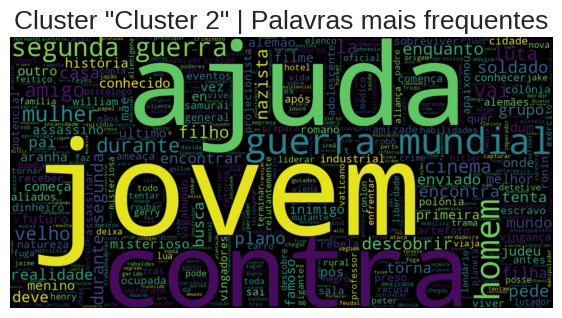

Cluster 3


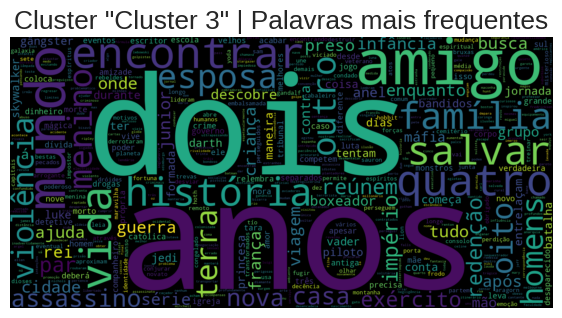

Cluster 1


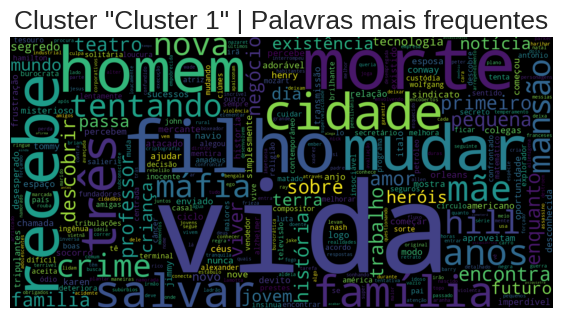

In [53]:
list_clusters = df_kmeans_all.Cluster.unique().tolist()
for c in list_clusters:
  print(c)
  if str(c) != "nan":
    word_cloud_cluster(c)

** Diferentemente do notebook que foi utilizado anteriormente, usando kmeans, e metodos como Davies Boundin Score e Calisnki, neste notebook, podemos obter uma analise diferenciada, ao utilizar apenas uma feature, e posteriormente, o uso de mais features do nosso dataset de filmes, (que foi retroalimentado durante alguns dias, atravez de um crawler do site imdb movies. 

Ao todo foram extraidas 357 amostras), entretanto, devida ao baixo numero de amostras, nao foi possivel atender exatamente aos clusters necessarios, vale salientar, que, no notebook que foi utilizado os metodos de Davies e Calinski, foram obtidos resultados mais satisfatorios. Vale a pena o teste para ver qual o melhor modelo para o nosso app de recomendacao.**

1. Na secao de Setuo (usando mais de uma feature), foi utilizada uma abordagem, Kmeans. Logo de cara ja vemos uma melhora nas metricas, Silhouette, Calinski e Davies!



2. Depois, foi analisados os plots dos modelos, que nos metodos de 'elbow', 'silhouette', 'distribution', 'cluster' e 'tsne'.
  
  2.1 Metodo Cluster: Em uma visao 2D da reducao de dimensionalidade (PCA), agora e possivel ver com exatidadao a separacao de cada cluster!
  
  2.2 Metodo TSNE: Com esta visualizacao, foi possivel ter uma boa identificacao da separacao exata dos clusters, em uma visao tridimencional. Agora pode-se destacar a quantidade de amostras exacerbadas de generos de Drama.
  
  2.3 Metodo de Silhouette: Ja as sihlouetas para cada cluster detectado pelo modelo apresentaram bons valores de coeficiente. Sendo possivel identificar a media de cada Label de cada cluster.
  
  2.4 Metodo de Distribution: Apesar de poucas amostras no dataset, o modelo conseguiu separar em 4 clusters quase que igualmente todas as amostras.
  


3. Depois foi analisado o % de cada gênero por cluster, sendo os dois gêneros mais representativos do:
  
  2.1 Todos os 4 clusters possuem todos os generos. Pode-se ver que a quantidade de amostras influenciou bastante no nivelamento da porcentagem.

  - Vale salientar que com o pycaret, os generos de Fantasia, e Faroeste, que na analise do notebook anterior, nao apareceram. 
  - Entretanto, no notebook anterior, sem o uso do Pycaret, os clusters nao tiveram uma diferenciacao significativa (10 clusters anteriormente).



4. E finalmente, foram apresentadas as nuvens de palavras por cluster, onde em linhas gerais destacam-se:
  
  6.1 Diferentemente do notebook anterior, os clusters nao apresentaram uma exatidao tao alta para com o filme Senhor dos aneis, porem um maior agrupamento por genero, que no caso, e o objetivo da atividade!
  
  6.2 Cluster 2: Jovem, Guerra mundial, segunda guerra, Alemao (Genero Acao, Acertou!!!)
  
  6.3 Cluster 0: Filho, Familia, Homem, Estados unidos, Politica, Cidade, Humanidade. (Genero Drama, Acertou!!!)
  
  6.4 Cluster 3: Historia, dois anos, Salvar, Familia, Mundo, Violencia, Assassino (Generos identificados: Drama, Policial, Aventura, Acredito que tenha acertado!)
  
  6.5 Cluster 1: Homem, Cidade, Morte, Vida, Salvar, Familia, Mafia. (Generos: Acao, Drama, Polial)



** Em resumo neste projeto foram aplicados conceitos de:


1. Webscraping / Crawler para coleta de dados do site IMDb



2. Pré-processamento de texto com utilização de técnicas de NLP, limpeza do texto, lemmatização, remoção de stopwords, remoção de pontuação, remoção de acentuação.



3. Tecnicas e abordagens diferentes para definir o numero adequado de clusters, que, a partir desses resultados, foi denifido que o numero de clusters mais adequado é o de 10 clusters, e conforme acima, foi possivel obter bons resultados, metodos:
 
  3.1 Metodo Elbow
  
  3.2 Metodo Silhouette
  
  3.3 Metodo Davies Bouldin Score
  
  3.4 Metodo Calinski Harabasz Score



4. Clusterização



5. Pycaret
  
  5.1 Utilizando tanto 1 quanto varias features para os clusters. 



Desta forma consideramos que o objetivo inicial foi atingido sendo possível a clusterização dos filmes baseado na sinopse / descrição de cada um, gerando desta forma a possibilidade de recomendar filmes aos usuários não apenas pela classificação tradicional por gêneros, mas também pelos clusters identificados neste projeto.

Os posters dos filmes foram extraidos do site tambem, para que assim, futuramente possamos realizar uma melhor analise com base nas imagens, e tambem, dar um melhor retorno ao solicitante, ao recomendar um filme!
A extraçao dessas imagens de posters foi feita atravez de webscrapping e arrays numpy, onde baixamos a imagem em ioBytes e a convertemos em escala de cinza, posteriormente em array numpy.

**Em termos práticos, se um usuário avalia positivamente um filme, os filmes pertecentes ao mesmo cluster podem ser recomendados a ele.**
